# Exploratory data analysis

Following the on-boarding docs and notebook. I use the latter to get supposedly "clean" data from .csv (originally another format) files. 

The purpose is to understand the data and how it relates to the theory outlined in other onboarding docs. 

**Some issues**

1. To have confidence in the data, I would like to verify the direct sun equation. Unfortunately, it is not straightforward with the existing data. 

    Some issues: 
    
    1. Need pressure column for each observation. Is it in `100hPa T`? Are the units appropriate for the direct sun equation? 
    2. Where do we get $\alpha$ and $\beta$ constants from? We could use the direct sun and infer them from a linear fit, but better if we had them
    3. There is a problem with device calibration, which affects $N_{1}$ via 
    $$N=L_0-L=\log{I_0/I_0^\prime}-\log{I/I^\prime}$$, 
    where $L_0$ needs to be calibrated. 
        * Is calibration supposed to be done using columns per wavelength, e.g. `L0(A)`, `L1(A)`? 
        * Let's look a the data for the wavelength to `A`: If `L0(A)` and `L1(A)` are as in direct sun equation, then what is `L(A)`?
        
3. What is the `constants` dataframe? Is it post-calibration? Calibration ideally should be done as part of the full model        
2. What is the deal with automatic vs manual measurements?


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
from pprint import pprint
from copy import deepcopy
import operator

from pprint import pprint, pp

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

import seaborn as sns
from tqdm.notebook import tqdm

import itertools
import functools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, max_error



# test-train split
from sktime.forecasting.model_selection import temporal_train_test_split

# plotter
from sktime.utils.plotting import plot_series

# forecasting horizon
from sktime.forecasting.base import ForecastingHorizon 

# performanc metric 
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# FORECASTERS

# list of available forecasters
from sktime.registry import all_estimators

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS


from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.fbprophet import Prophet

/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/sktime/utils/validation/series.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex)
/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:19: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.Per

ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/scipy/signal/signaltools.py)

# Load data

In [2]:
df_const = pd.read_pickle("df_const.pkl") # presumably, the result of calibration
df_direct = pd.read_pickle("df_direct.pkl")
df_zenith = pd.read_pickle("df_zenith.pkl")

In [3]:
df_direct.shape, df_zenith.shape

((3390, 53), (94378, 54))

## How do data fields in `df_direct` and `df_zenith` intersect and differ? 

In [4]:
df_direct.columns.intersection(df_zenith.columns)

Index(['Unnamed: 0', 'dt', 'Dobson', 'Lat', 'Lon', 'mu', 'zenith_angle',
       '100hPa T', 'Lo(A)', 'Lo(C)', 'Lo(D)', 'A1', 'A2', 'A3', 'C1', 'C2',
       'C3', 'D1', 'D2', 'L1(A)', 'L2(A)', 'L3(A)', 'L1(C)', 'L2(C)', 'L3(C)',
       'L1(D)', 'L2(D)', 'A', 'C', 'D', 'L(A)', 'L(C)', 'L(D)', 'cosSZA',
       'month', 'year', 'D073E', 'D031E', 'n1C_m_n2C', 'n1D_m_n2D',
       'n1A_m_n2A', 'nC_m_nD', 'nA_m_nD', 'nC_o_nD', 'nA_o_nD', 'secSZA',
       'nA_m_nD_o_mu', 'nC_m_nD_o_mu', 'invmu'],
      dtype='object')

In [13]:
df_zenith.dt

0       2012-02-04 15:46:00
1       2012-02-04 17:42:30
2       2012-02-05 12:45:30
3       2012-02-05 13:48:30
4       2012-02-05 14:48:00
                ...        
94373   2020-10-26 00:35:00
94374   2020-10-26 00:40:00
94375   2020-10-26 00:45:00
94376   2020-10-26 00:50:00
94377   2020-10-26 00:55:00
Name: dt, Length: 94378, dtype: datetime64[ns]

In [14]:
df_direct.dt

0      2012-02-05 18:08:00
1      2012-02-05 19:36:00
2      2012-02-06 14:51:00
3      2012-02-06 16:35:00
4      2012-02-06 17:35:00
               ...        
3385   2020-01-29 09:24:00
3386   2020-01-29 12:12:00
3387   2020-01-29 18:00:00
3388   2020-01-29 22:00:00
3389   2020-01-30 09:24:00
Name: dt, Length: 3390, dtype: datetime64[ns]

In [8]:
df_direct.columns.difference(df_zenith.columns), df_zenith.columns.difference(df_direct.columns)

(Index(['OZAD', 'OZCD', 'type1', 'type2'], dtype='object'),
 Index(['L(A)_uncalib', 'L(C)_uncalib', 'L(D)_uncalib', 'cloud', 'type'], dtype='object'))

In [9]:
# nm = df_direct.columns.intersection(df_zenith.columns)
# df_direct[nm]-df_zenith[nm]

## Geo location

These are pretty much the same for both, direct and zenith series

In [64]:
df_direct['Lat'].unique(), df_direct['Lon'].unique(), 

(array([-75.6119, -75.6115, -75.611 , -75.6105, -75.61  , -75.5704,
        -75.569 ]),
 array([-26.21  , -26.2242, -26.2388, -26.2544, -26.2709, -25.468 ,
        -25.4889]))

In [65]:
df_zenith['Lat'].unique(), df_zenith['Lon'].unique(), 

(array([-75.6119, -75.6115, -75.611 , -75.6105, -75.61  , -75.5704,
        -75.569 , -75.57  ]),
 array([-26.21  , -26.2242, -26.2388, -26.2544, -26.2709, -25.468 ,
        -25.4889, -25.49  ]))

## Plot time series

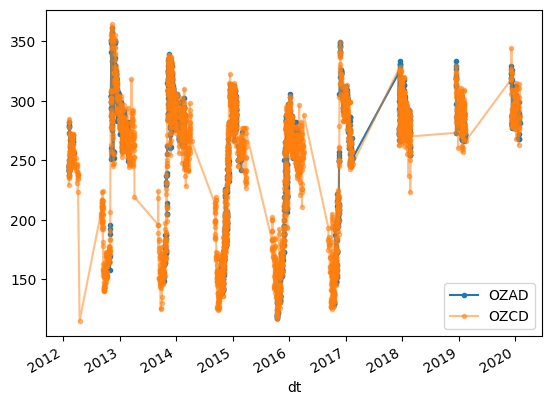

In [19]:
%matplotlib inline
ax = df_direct.plot('dt', 'OZAD', style = '.-');
df_direct.plot('dt', 'OZCD', ax = ax, alpha = .5, style = '.-');

In [90]:
df = pd.DataFrame(index = df_direct['dt'], columns = ['OZCD'])

In [180]:
df = df_direct.drop(columns = 'Unnamed: 0').set_index('dt')
df.index.name = None
df['OZCD'] = df['OZCD'].astype(float)

For some reason, two dates are identified as duplicates. Weird

In [191]:
df.index.duplicated().sum()

2

In [175]:
df['OZCD'][~df.index.duplicated()]

2012-02-05 18:08:00    248.0
2012-02-05 19:36:00    254.0
2012-02-06 14:51:00    238.0
2012-02-06 16:35:00    242.0
2012-02-06 17:35:00    245.0
                       ...  
2020-01-29 09:24:00    311.0
2020-01-29 12:12:00    295.0
2020-01-29 18:00:00    299.0
2020-01-29 22:00:00    281.0
2020-01-30 09:24:00    286.0
Name: OZCD, Length: 3388, dtype: float64

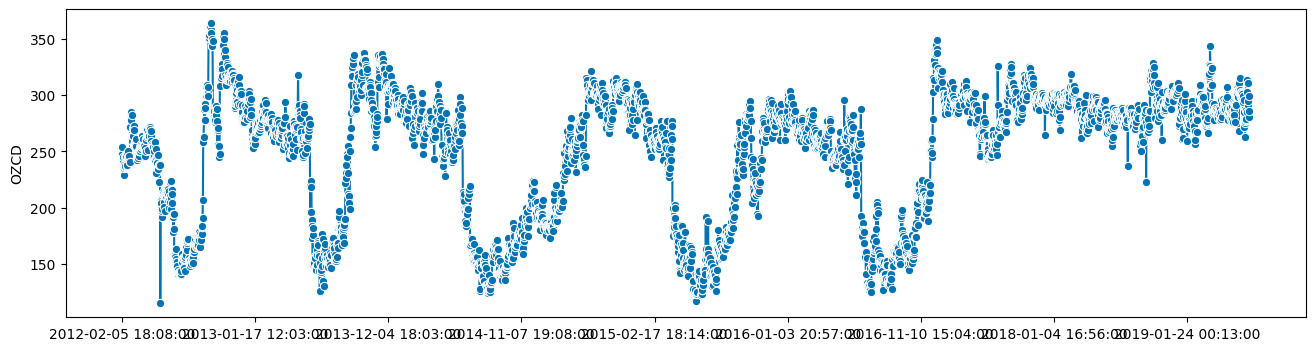

In [197]:
%matplotlib inline
plot_series(df['OZCD'][~df.index.duplicated()]);

<AxesSubplot: xlabel='dt'>

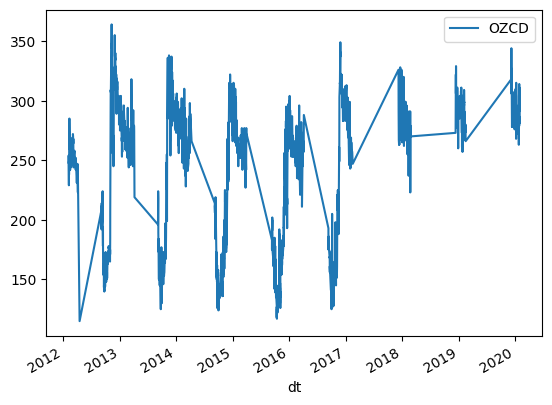

In [205]:
df_direct.plot('dt', 'OZCD')

# Linear regression of direct sun

Verify that the following holds
$$X_{12}=\frac{N_{12}}{\Delta\alpha_{12}\mu}-\frac{\Delta\beta_{12}p}{\Delta\alpha_{12}\mu}$$

By fitting a linear model for $k$ and $b$:

$$X_{12}=k \frac{N_{12}}{\mu} + b$$

In [10]:
sample_size = 1000

df_sample = df_direct[['nC_m_nD_o_mu', 'OZCD', 'nA_m_nD_o_mu', 'OZAD' ]]\
.dropna()\
.sample(sample_size)

df_sample

,nC_m_nD_o_mu,OZCD,nA_m_nD_o_mu,OZAD
30,0.433278,264,0.393961,262.0
2491,0.503357,300,0.452015,303.0
2945,0.475245,292,0.431133,290.0
772,0.510627,307,0.461493,311.0
953,0.469685,294,0.435973,294.0
...,...,...,...,...
849,0.469143,277,0.418414,281.0
915,0.448784,277,0.407941,274.0
18,0.403638,244,0.368516,245.0
3285,0.480182,285,0.427295,287.0


In [11]:
modelCD = LinearRegression()
modelAD = LinearRegression()

In [12]:
Xcd_train, Xcd_test, Ycd_train, Ycd_test = train_test_split(
        df_sample['nC_m_nD_o_mu'], df_sample['OZCD'],
        test_size=0.5
)

In [13]:
Xad_train, Xad_test, Yad_train, Yad_test = train_test_split(
        df_sample['nA_m_nD_o_mu'], df_sample['OZAD'],
        test_size=0.5
)

In [15]:
modelCD.fit(Xcd_train.to_numpy().reshape(-1,1), Ycd_train.to_numpy().reshape(-1,1))
modelAD.fit(Xad_train.to_numpy().reshape(-1,1), Yad_train.to_numpy().reshape(-1,1))

LinearRegression()

In [16]:
pred_Ycd = modelCD.predict(Xcd_test.to_numpy().reshape(-1,1))
pred_Yad = modelAD.predict(Xad_test.to_numpy().reshape(-1,1))

In the following, I wanted to see the same line. However we see that 
1. ozone obtained from `CD` has a bit more noise than from `AD`
2. the slope of the lines is similar, which means $\Delta\alpha_{12}$ is the same. 
3. the intercepts of the lines are different, which means that either $\Delta\beta_{12}$ or $p$ are different between the measurements

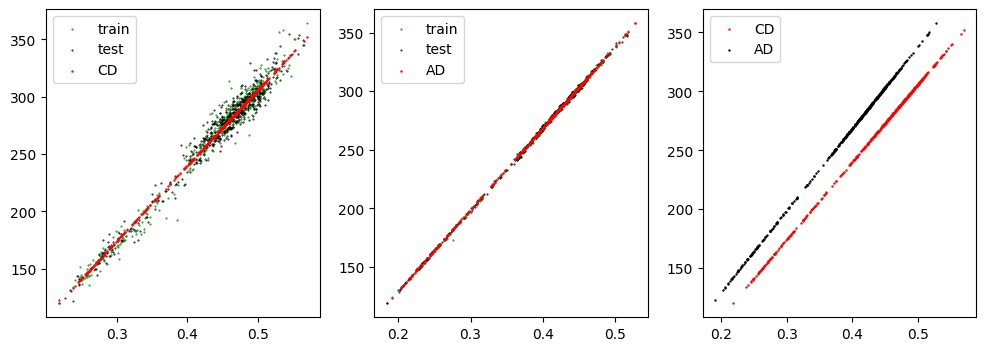

In [29]:
plt.figure(figsize = (12, 4))

plt.subplot(1,3,1)
plt.scatter(Xcd_test, Ycd_test, .2, 'g');
plt.scatter(Xcd_train, Ycd_train, .2, 'k');
plt.scatter(Xcd_test, pred_Ycd, .5, 'r');
plt.legend(['train', 'test', 'CD']);

plt.subplot(1,3,2)
plt.scatter(Xad_test, Yad_test, .2, 'g');
plt.scatter(Xad_train, Yad_train, .2, 'k');
plt.scatter(Xad_test, pred_Yad, .5, 'r');
plt.legend(['train', 'test', 'AD']);

plt.subplot(1,3,3)
plt.scatter(Xcd_test, pred_Ycd, .5, 'r');
plt.scatter(Xad_test, pred_Yad, .5, 'k');

plt.legend(['CD', 'AD']);
